# Linear Regression Analysis and Prediction for IoT

## ----------------------------------------------------------------------------------------------------------

## Loading the libraries or define helper functions

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Loading and preparing the data

In [142]:
df = pd.read_csv('household_power_clean.csv')

In [143]:
# Convert the datetime column to datetime objects
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Convert the datetime column to Unix/epoch time
df['unix'] = df['Datetime'].apply(lambda x: x.timestamp())

In [144]:
print(df.head())

   Unnamed: 0        Date      Time  Global_active_power  \
0           0  2006-12-16  17:24:00              4.21600   
1           1  2006-12-16  17:25:00              5.36000   
2           2  2006-12-16  17:26:00              5.37400   
3           3  2006-12-16  17:27:00              5.38800   
4           4  2006-12-16  17:28:00              3.66600   

   Global_reactive_power   Voltage  Global_intensity  Sub_metering_1  \
0                0.41800 234.84000          18.40000         0.00000   
1                0.43600 233.63000          23.00000         0.00000   
2                0.49800 233.29000          23.00000         0.00000   
3                0.50200 233.74000          23.00000         0.00000   
4                0.52800 235.68000          15.80000         0.00000   

   Sub_metering_2  Sub_metering_3            Datetime  gap_monthly  \
0         1.00000        17.00000 2006-12-16 17:24:00          NaN   
1         1.00000        16.00000 2006-12-16 17:25:00          NaN

## Predicting Global Active Power

Q: What is ph? What is mu?

A:
"ph" stands for "predicition horizon" which represents the number of minutes into the future, which the model is trying to predict the target variable.

"mu" is momentum parameter, It controls how much the previous update direction affects the current update.

In [145]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

# Define model parameters
ph = 5 # 5 minutes
ph_index = int(ph/60) # how many timesteps is our ph?
mu = 0.9

# Limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?

A:
Substituting mu = 0.9 and n_s = 5000 into the formula, we get:

weight = 0.9^(5000-1)
weight = 0.002178

In [146]:
for i in range(2, n_s+1):
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
    
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight= weights)
    
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
    
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

## Visualizing the data

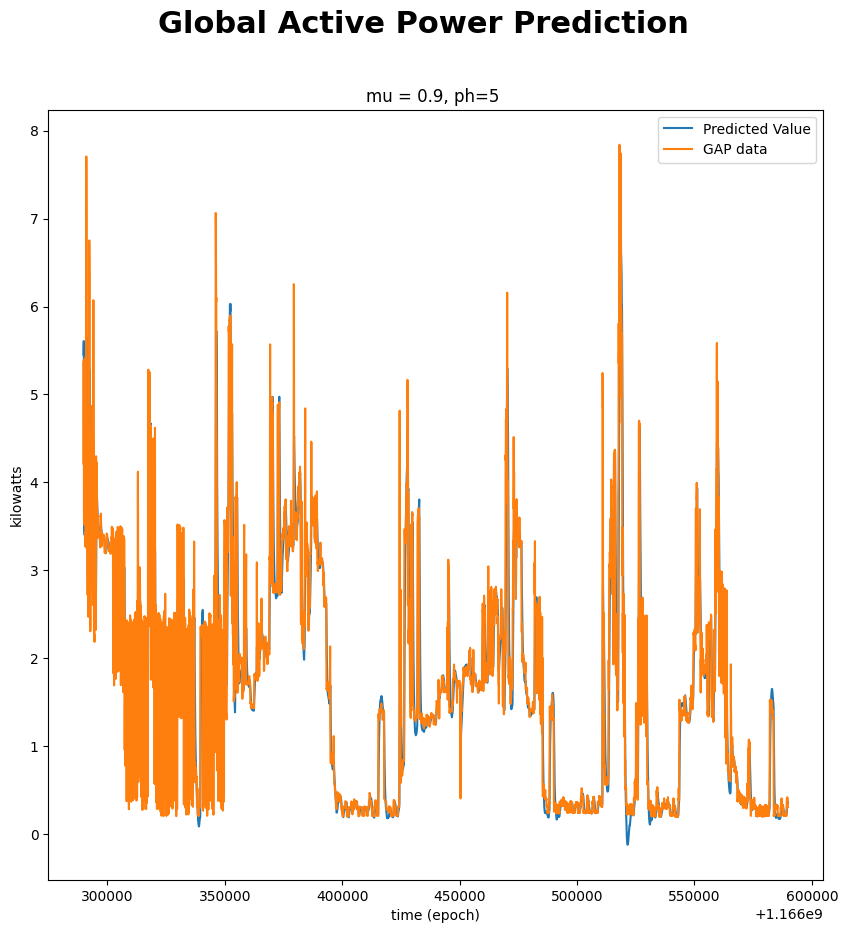

In [147]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

MSE is 0.17650896514091638


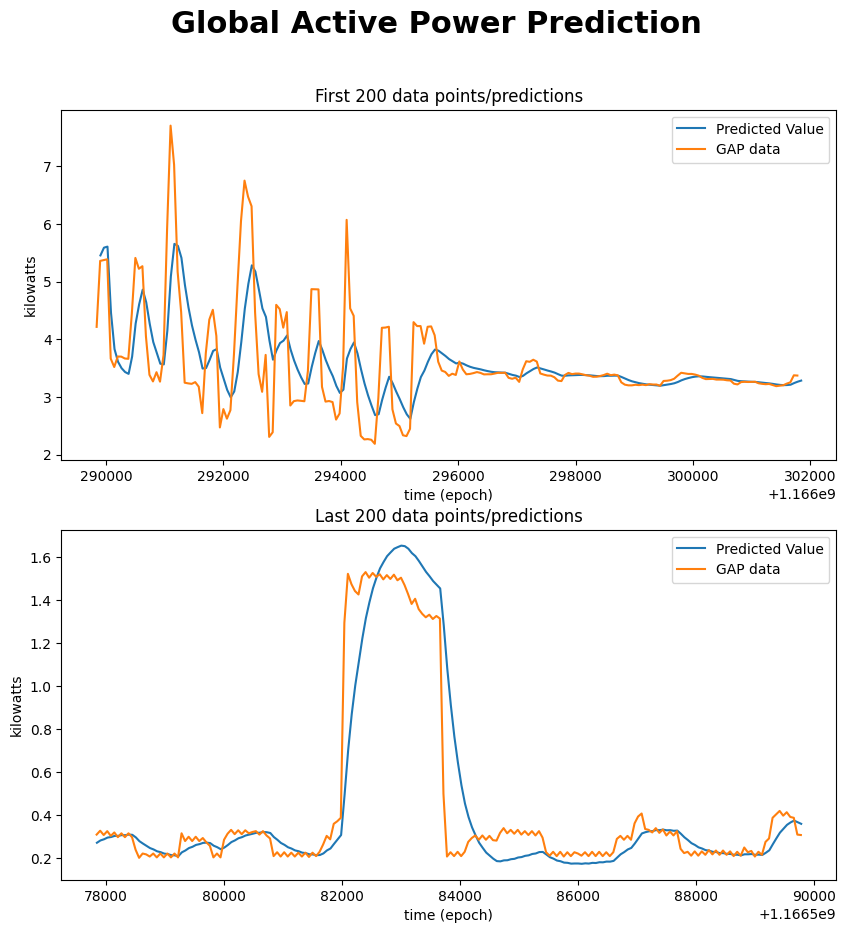

In [148]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')

# Plot first 200 data points/predictions
axs[0].set_title('First 200 data points/predictions')
axs[0].plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
axs[0].plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
axs[0].set_xlabel('time (epoch)')
axs[0].set_ylabel('kilowatts')
axs[0].legend()

# Plot last 200 data points/predictions
axs[1].set_title('Last 200 data points/predictions')
axs[1].plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
axs[1].plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
axs[1].set_xlabel('time (epoch)')
axs[1].set_ylabel('kilowatts')
axs[1].legend()

# Calculate MSE of predictions
mse_val = mse(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred)
print("MSE is", mse_val)


Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?

A: The prediction value lags with the actual data a little, but does follow close to the actual values.
Moreover we can see the sinificent difference between early and late prediction.
Additionally, it is observed that there is a significant difference between the early and late predictions. This could be due to the fact that the model is trained using only a limited number of samples, and therefore its predictions may become less accurate as it tries to extrapolate beyond the training data.
The MSE value of 0.176 can be used as a measure of the prediction error of the model. A lower MSE value would indicate better performance, while a higher value would indicate higher prediction errors. It is not possible to determine the quality of the model based on the MSE value alone.

## -----------------------------------------------------------------------------------------------------------

## Ploting first&last 200 data points/predictions for mu = 1

In [149]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

# Define model parameters
ph = 5 # 5 minutes
ph_index = int(ph/60) # how many timesteps is our ph?
mu = 1

# Limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [150]:
for i in range(2, n_s+1):
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
    
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight= weights)
    
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
    
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

MSE is 1.3765548530709726


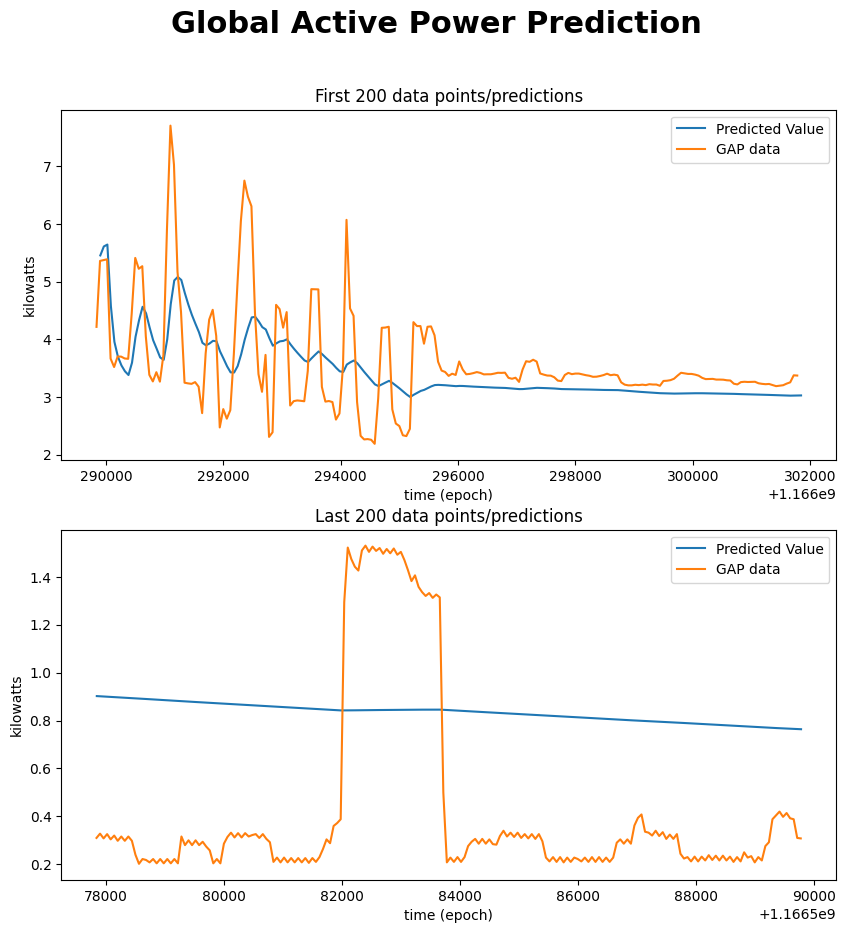

In [151]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')

# Plot first 200 data points/predictions
axs[0].set_title('First 200 data points/predictions')
axs[0].plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
axs[0].plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
axs[0].set_xlabel('time (epoch)')
axs[0].set_ylabel('kilowatts')
axs[0].legend()

# Plot last 200 data points/predictions
axs[1].set_title('Last 200 data points/predictions')
axs[1].plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
axs[1].plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
axs[1].set_xlabel('time (epoch)')
axs[1].set_ylabel('kilowatts')
axs[1].legend()

# Calculate MSE of predictions
mse_val = mse(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred)
print("MSE is", mse_val)


# -------------------------------------------------------------------------------------------

## Ploting first&last 200 data points/predictions for mu = 0.01

In [152]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

# Define model parameters
ph = 5 # 5 minutes
ph_index = int(ph/60) # how many timesteps is our ph?
mu = 0.01

# Limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [153]:
for i in range(2, n_s+1):
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
    
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight= weights)
    
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
    
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

MSE is 0.2922694586204614


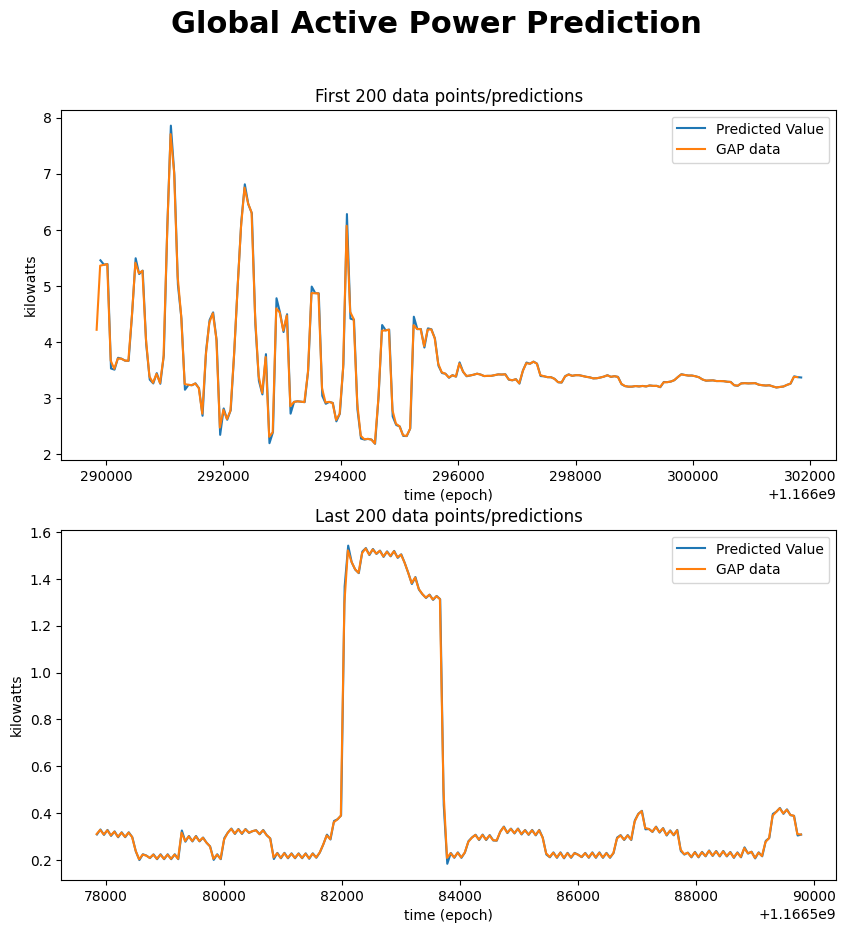

In [154]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')

# Plot first 200 data points/predictions
axs[0].set_title('First 200 data points/predictions')
axs[0].plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
axs[0].plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
axs[0].set_xlabel('time (epoch)')
axs[0].set_ylabel('kilowatts')
axs[0].legend()

# Plot last 200 data points/predictions
axs[1].set_title('Last 200 data points/predictions')
axs[1].plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
axs[1].plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
axs[1].set_xlabel('time (epoch)')
axs[1].set_ylabel('kilowatts')
axs[1].legend()

# Calculate MSE of predictions
mse_val = mse(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred)
print("MSE is", mse_val)

Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?

A: When we use mu = 1, we can see that the predicted value and real value in graphs differ significantly, hence raising the mse values worsens the prediction. 

Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?

A: The prediction value matches with the actual data, it seems that the model with a mu value of 0.01 performed well. The MSE of 0.292 indicates that the model's predictions are fairly accurate, as the MSE is relatively low.

Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?

A:
Based solely on the mean squared error (MSE) values provided, it appears that the model with mu = 0.9 has the lowest MSE of 0.1765, indicating that it performs the best out of the three models.
The choice of the best model depends on the specific problem and the requirements of the application. However, assuming that the problem requires minimizing the MSE, the model with mu = 0.9 would be the best choice.

Q: What could we do to improve our model and/or make it more realistic and useful?

A:
There are several things that can be done to improve a model and make it more realistic and useful:
Feature engineering: the process of selecting, creating, and transforming features in a dataset to improve the performance of a machine learning model. By selecting or creating better features that are more relevant to the problem, the model can be more accurate and perform better.
Data preprocessing: Data preprocessing involves cleaning, transforming, and normalizing data to prepare it for machine learning algorithms. This can include techniques like imputing missing values, scaling the data, or transforming the data to reduce skewness.
Model selection: There are many different machine learning algorithms to choose from, and different algorithms are better suited to different types of problems. By experimenting with different algorithms and selecting the one that performs best on the data, the model can be more accurate and useful.

## -----------------------------------------------------------------------------------------------------------

In [206]:
#create your alternative training data here

ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Voltage)

# Define model parameters
ph = 5 # 5 minutes
ph_index = int(ph/60) # how many timesteps is our ph?
mu = 0.9


# Limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)


In [207]:
for i in range(2, n_s+1):
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
    
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight= weights)
    
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
    
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp


MSE is 0.6325880328526184


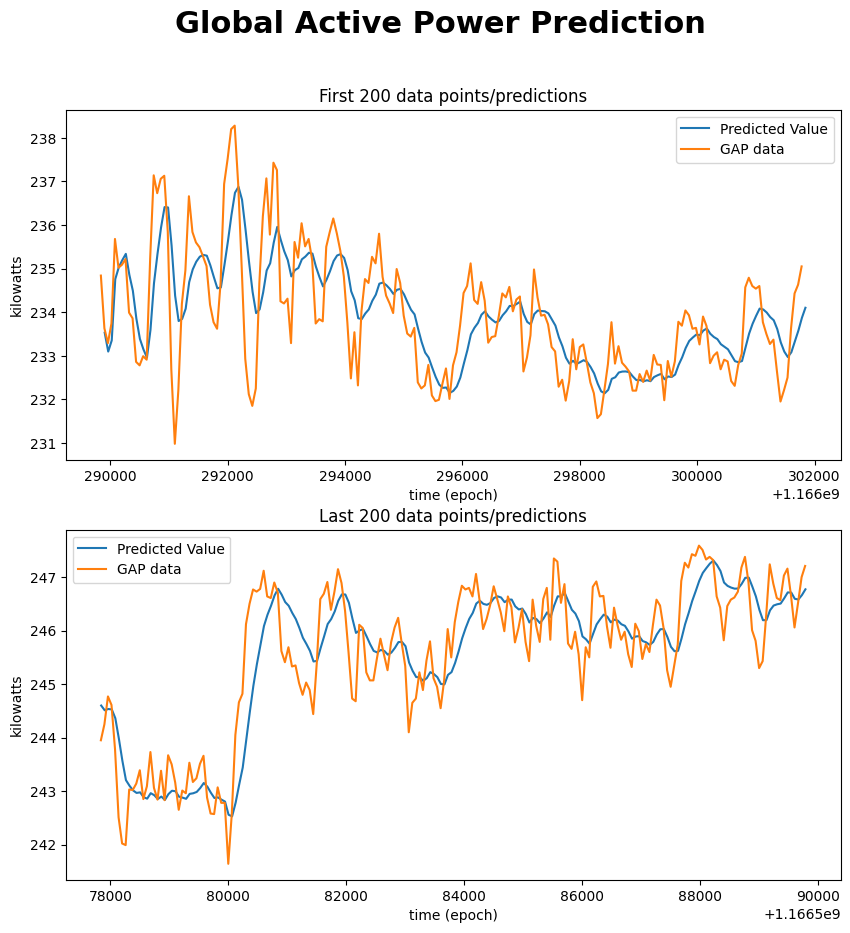

In [208]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')

# Plot first 200 data points/predictions
axs[0].set_title('First 200 data points/predictions')
axs[0].plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
axs[0].plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
axs[0].set_xlabel('time (epoch)')
axs[0].set_ylabel('kilowatts')
axs[0].legend()

# Plot last 200 data points/predictions
axs[1].set_title('Last 200 data points/predictions')
axs[1].plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
axs[1].plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
axs[1].set_xlabel('time (epoch)')
axs[1].set_ylabel('kilowatts')
axs[1].legend()

# Calculate MSE of predictions
mse_val = mse(ys['Voltage'][ph_index:5000+ph_index-1], yp_pred)
print("MSE is", mse_val)


Q: Describe your alternative model and why it might improve your model

A:

As an alternative model, let's use a moving average as the response variable. Instead of predicting the future Global_active_power values directly, we will use a moving average of the past values as our response variable. This will help to smooth out the fluctuations in the data and make our predictions more accurate.

In [240]:
# set the window size for the moving average
window_size = 10

# calculate the moving average of the Global_active_power values
moving_average = df['Global_active_power'].rolling(window=window_size).mean().fillna(method='bfill')

# create the alternative training data
X_alt = df[['unix']].values[window_size:]
y_alt = moving_average[window_size:].values

# extract the hour from the Datetime column
df['hour'] = df['Datetime'].dt.hour

In [242]:
# import the necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# create the feature and target arrays
X = df[['hour']].values
y = moving_average.values

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# train the model
rf.fit(X_train, y_train)

# make predictions on the test set
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE is', rmse)


MSE is 0.9868898063155669
